In [ ]:
import os
import matplotlib.pyplot as plt
import random

from data.dataloader import *
from data.utils import *
from model.model import *
from engine import *


/home/user/anaconda3/envs/jih_icicic/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def get_hparams():
    hparams = {
        # 모델 구조
        "image_size": 512,
        "offset": 0.5,
        "cutoff": 0.3,

        # 손실 함수 가중치 (losses.py 기준)
        "lambda_col": 100.0,
        "lambda_exp": 1.0,
        "lambda_spa": 10.0,
        "lambda_tva": 1.0,

        # 최적화 및 학습 설정
        "optim": "sgd",
        "lr": 1e-7,
        "decay": 1e-8,
        "epochs": 100,
        "patience": 30,
        "batch_size": 16,
        "seed": random.randint(a=0, b=10000),

        # 데이터 경로
        "train_data_path": "data/1_train",
        "valid_data_path": "data/2_valid",
        "bench_data_path": "data/3_bench",
        "infer_data_path": "data/4_infer",

        # 로깅 설정
        "log_dir": "./runs/HomomorphicUnet/optims/ReduceActz",
        "experiment_name": "test",
        "inference": "inference",
    }
    return hparams


hparams = get_hparams()


In [ ]:
engine = LightningEngine(
    model=HomomorphicUnetLightning,
    hparams=hparams,
    ckpt="runs/HomomorphicUnet/optims/ReduceActz/rmsprop/version_0/nan_ckpt.ckpt"
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
transform = DataTransform(image_size=512)
dataset = CustomDataset(path="data/3_bench/DICMdataset", transform=transform)
loader = DataLoader(
    dataset=dataset,
    batch_size=1,
    shuffle=True,
    num_workers=int(os.cpu_count() * 0.9),
    persistent_workers=True,
    pin_memory=True
)

d_b = next(iter(loader))


In [ ]:
hsirL = engine.model(hparams)
hsir = hsirL.model


Loading pretrained model LPIPS from /home/user/.cache/torch/hub/pyiqa/LPIPS_v0.1_alex-df73285e.pth


In [ ]:
y_b, cr_b, cb_b = hsir.rgb2ycrcb(d_b)
xi_b, xd_b = hsir.homo_separate(y_b)
oi_b = hsir.unet(xi_b)
ni_b = hsir.refine(xi_b, oi_b)
ny_b = ni_b * xd_b
eh_b = hsir.ycrcb2rgb(ny_b, cr_b, cb_b)


In [ ]:
d = d_b[0]
y, cr, cb = y_b[0], cr_b[0], cb_b[0]
xi, xd = xi_b[0], xd_b[0]
oi = oi_b[0]
ni = ni_b[0]
ny = ny_b[0]
eh = eh_b[0]


In [ ]:
d = d.permute(1, 2, 0)
y, cr, cb = y.permute(1, 2, 0), cr.permute(1, 2, 0), cb.permute(1, 2, 0)
xi, xd = xi.permute(1, 2, 0), xd.permute(1, 2, 0)
oi = oi.permute(1, 2, 0).detach().numpy()
ni = ni.permute(1, 2, 0).detach().numpy()
ny = ny.permute(1, 2, 0).detach().numpy()
eh = eh.permute(1, 2, 0).detach().numpy()


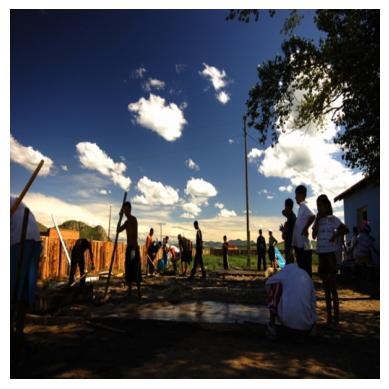

In [ ]:
plt.imshow(d)
plt.axis(False)
plt.show()


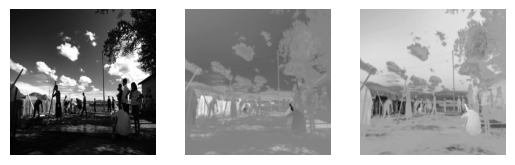

In [ ]:
plt.subplot(1, 3, 1)
plt.imshow(y, 'gray')
plt.axis(False)

plt.subplot(1, 3, 2)
plt.imshow(cr, 'gray')
plt.axis(False)

plt.subplot(1, 3, 3)
plt.imshow(cb, 'gray')
plt.axis(False)
plt.show()


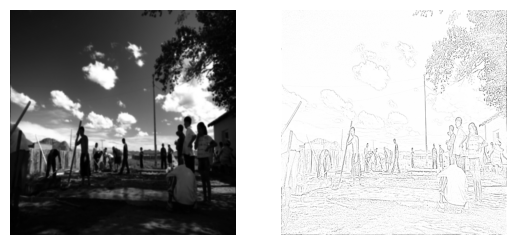

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(xi, 'gray')
plt.axis(False)

plt.subplot(1, 2, 2)
plt.imshow(xd, 'gray')
plt.axis(False)
plt.show()


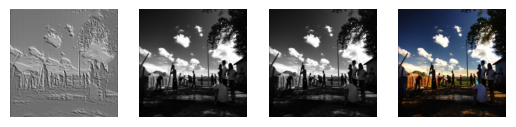

In [ ]:
plt.subplot(1, 4, 1)
plt.imshow(oi, 'gray')
plt.axis(False)

plt.subplot(1, 4, 2)
plt.imshow(ni, 'gray')
plt.axis(False)

plt.subplot(1, 4, 3)
plt.imshow(ny, 'gray')
plt.axis(False)

plt.subplot(1, 4, 4)
plt.imshow(eh)
plt.axis(False)
plt.show()
